# Parameter embedding

We have tried to use learned embedding on stock id. We now attempt method of parameter (continuous) embedding on row id's in hope that it contains more information than only the learned embedding of stock id's. This method should also have the capability of "telling which row id's are similar" by adjusting its embedding in training. 

### Imports

In [34]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

In [2]:
#Only run this cell if needed. AMD gpus might need this. 
from dotenv import load_dotenv
import os

load_dotenv("../dotenv_env/deep_learning.env")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # To, possibly fix memory leak issues. 

print(os.environ.get("HSA_OVERRIDE_GFX_VERSION"))

10.3.0


In [3]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


### Load in data

#### time id

In [4]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

#### timeseries 

In [5]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

#### Target

In [6]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


#### Tab data

In [7]:
df_tab=pd.read_csv("../processed_data/trade_vals_by_row_id.csv")

Our goal is to embed the values 'price_mean', 'price_std', 'size_sum', 'size_mean', 'size_std', 'order_count_sum', 'order_count_mean', and 'order_count_std' as "representatives" of the "row id". They should provide a description of the "row_id" as a vector. 

In [8]:
df_tab.columns

Index(['price_mean', 'price_std', 'size_sum', 'size_mean', 'size_std',
       'order_count_sum', 'order_count_mean', 'order_count_std', 'row_id'],
      dtype='object')

In [35]:
df_tab["time_id"]=df_tab["row_id"].apply(lambda x: x.split("-")[-1]).astype(int)
df_tab["stock_id"]=df_tab["row_id"].apply(lambda x: x.split("-")[0]).astype(int)

In [36]:
df_tab

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,stock_id
0,1.003722,0.000578,3179,79.475000,118.375107,110,2.750000,2.467741,0-5,5,0
1,1.000206,0.000304,1289,42.966667,77.815203,57,1.900000,1.446756,0-11,11,0
2,0.999204,0.000932,2161,86.440000,113.587000,68,2.720000,2.300725,0-16,16,0
3,0.999020,0.000729,1962,130.800000,144.828569,59,3.933333,4.043808,0-31,31,0
4,0.999618,0.000182,1791,81.409091,117.914682,89,4.045455,4.099678,0-62,62,0
...,...,...,...,...,...,...,...,...,...,...,...
428908,1.000635,0.000431,48894,474.699029,534.042552,494,4.796117,4.598293,99-32751,32751,99
428909,1.000694,0.000664,48635,528.641304,717.778741,585,6.358696,6.732864,99-32753,32753,99
428910,0.998246,0.000552,50438,600.452381,1177.948006,457,5.440476,7.490317,99-32758,32758,99
428911,0.998905,0.000309,47020,283.253012,372.698606,588,3.542169,3.248501,99-32763,32763,99


We then can create the total dataframe where we can also do parameter embedding on stock_id and time_id with function data_processing.create_df_param_emb_by_group. 

In [40]:
df_total=data_processing.create_df_param_emb_by_group(df_in=df_tab,str_groupby="time_id",dict_params_aggfun={"price_mean":["mean","std"],"size_sum":["mean","std"],"order_count_sum":["mean","std"]})
df_total=data_processing.create_df_param_emb_by_group(df_in=df_total,str_groupby="stock_id",dict_params_aggfun={"price_mean":["mean","std"],"size_sum":["mean","std"],"order_count_sum":["mean","std"]})

In [41]:
df_total

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,...,size_sum_time_id_mean,size_sum_time_id_std,order_count_sum_time_id_mean,order_count_sum_time_id_std,price_mean_stock_id_mean,price_mean_stock_id_std,size_sum_stock_id_mean,size_sum_stock_id_std,order_count_sum_stock_id_mean,order_count_sum_stock_id_std
0,1.003722,0.000578,3179,79.475000,118.375107,110,2.750000,2.467741,0-5,5,...,30157.767857,55732.656856,444.491071,537.485453,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
1,1.000206,0.000304,1289,42.966667,77.815203,57,1.900000,1.446756,0-11,11,...,13469.392857,17787.844183,211.642857,183.786297,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
2,0.999204,0.000932,2161,86.440000,113.587000,68,2.720000,2.300725,0-16,16,...,16911.339286,19486.725826,215.535714,174.054767,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
3,0.999020,0.000729,1962,130.800000,144.828569,59,3.933333,4.043808,0-31,31,...,12592.973214,18627.884667,177.794643,161.292479,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
4,0.999618,0.000182,1791,81.409091,117.914682,89,4.045455,4.099678,0-62,62,...,11393.486486,14562.028835,179.819820,146.265214,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428908,1.000635,0.000431,48894,474.699029,534.042552,494,4.796117,4.598293,99-32751,32751,...,20214.080357,27428.487093,311.312500,256.636492,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
428909,1.000694,0.000664,48635,528.641304,717.778741,585,6.358696,6.732864,99-32753,32753,...,20996.589286,29343.947115,312.000000,288.377662,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
428910,0.998246,0.000552,50438,600.452381,1177.948006,457,5.440476,7.490317,99-32758,32758,...,13626.875000,22949.301781,176.258929,202.530378,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
428911,0.998905,0.000309,47020,283.253012,372.698606,588,3.542169,3.248501,99-32763,32763,...,42114.571429,64263.609236,449.339286,348.921648,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784


As a proof, see following example sampling. 

First, on the time_id 

In [45]:
df_total[df_total["time_id"]==5].sample(5)

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,...,size_sum_time_id_mean,size_sum_time_id_std,order_count_sum_time_id_mean,order_count_sum_time_id_std,price_mean_stock_id_mean,price_mean_stock_id_std,size_sum_stock_id_mean,size_sum_stock_id_std,order_count_sum_stock_id_mean,order_count_sum_stock_id_std
229764,1.005578,0.001315,79850,259.253247,456.235789,1197,3.886364,4.729498,44-5,5,...,30157.767857,55732.656856,444.491071,537.485453,1.000031,0.003635,92530.225326,85280.129493,847.436031,648.433034
371463,1.003314,0.000818,34876,186.502674,368.600570,699,3.737968,4.607241,84-5,5,...,30157.767857,55732.656856,444.491071,537.485453,1.000013,0.003421,36520.158225,27257.822611,644.496867,434.369219
214444,1.001612,0.000737,4082,80.039216,155.403727,154,3.019608,3.029787,40-5,5,...,30157.767857,55732.656856,444.491071,537.485453,0.999864,0.003559,3906.265796,3940.966817,145.449086,107.905068
333174,1.005578,0.001080,22567,402.982143,571.472150,317,5.660714,6.729249,74-5,5,...,30157.767857,55732.656856,444.491071,537.485453,0.999986,0.004402,27305.490601,20444.955902,302.569191,195.975899
402103,1.002227,0.001003,35728,140.109804,165.359986,815,3.196078,2.865898,93-5,5,...,30157.767857,55732.656856,444.491071,537.485453,1.000014,0.002169,22521.141775,15622.252281,397.549086,243.154093


In [46]:
df_total[df_total["time_id"]==11].sample(5)

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,...,size_sum_time_id_mean,size_sum_time_id_std,order_count_sum_time_id_mean,order_count_sum_time_id_std,price_mean_stock_id_mean,price_mean_stock_id_std,size_sum_stock_id_mean,size_sum_stock_id_std,order_count_sum_stock_id_mean,order_count_sum_stock_id_std
425084,1.000482,0.000495,35786,639.035714,748.432956,419,7.482143,7.427201,99-11,11,...,13469.392857,17787.844183,211.642857,183.786297,0.999968,0.002766,50414.991384,55170.684660,553.923238,516.955784
53619,1.001251,0.000518,46432,748.903226,656.813987,517,8.338710,6.358017,111-11,11,...,13469.392857,17787.844183,211.642857,183.786297,1.000068,0.002983,123460.030548,128439.583028,1037.108094,930.840993
233595,1.000087,0.000276,21051,679.064516,911.636767,236,7.612903,7.766069,46-11,11,...,13469.392857,17787.844183,211.642857,183.786297,0.999943,0.002265,39009.975196,30372.977707,378.090862,281.968454
179991,1.000520,0.000400,44729,2354.157895,2422.309074,188,9.894737,7.038740,32-11,11,...,13469.392857,17787.844183,211.642857,183.786297,0.999989,0.002973,159425.110705,150535.679398,545.075718,529.463206
279555,1.001236,0.000599,9598,154.806452,247.452982,284,4.580645,5.661340,6-11,11,...,13469.392857,17787.844183,211.642857,183.786297,1.000035,0.006120,33156.159269,39955.831343,646.667624,679.817105


Then, on the stock_id

In [47]:
df_total[df_total["stock_id"]==0].sample(5)

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,...,size_sum_time_id_mean,size_sum_time_id_std,order_count_sum_time_id_mean,order_count_sum_time_id_std,price_mean_stock_id_mean,price_mean_stock_id_std,size_sum_stock_id_mean,size_sum_stock_id_std,order_count_sum_stock_id_mean,order_count_sum_stock_id_std
1150,0.998554,0.001001,1571,49.093750,83.492074,73,2.281250,2.128673,0-9720,9720,...,27765.526786,50276.838405,308.758929,360.607901,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
1676,0.997680,0.000763,2403,96.120000,154.915923,70,2.800000,2.198484,0-13968,13968,...,16850.071429,33519.764787,179.830357,209.024068,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
1953,1.002374,0.000688,2803,82.441176,150.752294,119,3.500000,3.296003,0-16192,16192,...,22522.303571,43953.214156,255.133929,263.170225,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
1900,1.000730,0.000423,6255,122.647059,141.934890,159,3.117647,2.854099,0-15757,15757,...,23967.500000,33826.852294,299.633929,359.992142,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362
3363,0.988921,0.001471,1342,78.941176,104.236192,30,1.764706,1.393261,0-28371,28371,...,49658.437500,102711.110446,610.910714,959.808592,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362


In [48]:
df_total[df_total["stock_id"]==99].sample(5)

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,...,size_sum_time_id_mean,size_sum_time_id_std,order_count_sum_time_id_mean,order_count_sum_time_id_std,price_mean_stock_id_mean,price_mean_stock_id_std,size_sum_stock_id_mean,size_sum_stock_id_std,order_count_sum_stock_id_mean,order_count_sum_stock_id_std
428087,1.002270,0.001018,31054,333.913978,472.078859,330,3.548387,3.530969,99-25282,25282,...,23486.919643,41203.734806,306.223214,365.226666,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
427250,1.004616,0.002193,69518,469.716216,651.767957,813,5.493243,6.331539,99-17949,17949,...,81802.285714,143836.073318,862.892857,1210.025823,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
425633,1.003101,0.001071,43872,315.625899,529.500219,545,3.920863,4.402017,99-4547,4547,...,29389.535714,64684.627681,406.214286,553.212737,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
425156,0.999974,0.000602,24049,312.324675,353.587495,255,3.311688,2.987957,99-650,650,...,16223.196429,23886.221773,207.839286,191.340909,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784
428699,0.999922,0.000628,35368,353.680000,391.611766,437,4.370000,4.026817,99-30803,30803,...,23354.517857,35784.572245,338.973214,329.108527,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784


In [49]:
# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(df_total['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
df_total['emb_id'] = df_total['stock_id'].map(id_to_emb)
df_total

,price_mean,price_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,row_id,time_id,...,size_sum_time_id_std,order_count_sum_time_id_mean,order_count_sum_time_id_std,price_mean_stock_id_mean,price_mean_stock_id_std,size_sum_stock_id_mean,size_sum_stock_id_std,order_count_sum_stock_id_mean,order_count_sum_stock_id_std,emb_id
0,1.003722,0.000578,3179,79.475000,118.375107,110,2.750000,2.467741,0-5,5,...,55732.656856,444.491071,537.485453,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362,0
1,1.000206,0.000304,1289,42.966667,77.815203,57,1.900000,1.446756,0-11,11,...,17787.844183,211.642857,183.786297,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362,0
2,0.999204,0.000932,2161,86.440000,113.587000,68,2.720000,2.300725,0-16,16,...,19486.725826,215.535714,174.054767,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362,0
3,0.999020,0.000729,1962,130.800000,144.828569,59,3.933333,4.043808,0-31,31,...,18627.884667,177.794643,161.292479,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362,0
4,0.999618,0.000182,1791,81.409091,117.914682,89,4.045455,4.099678,0-62,62,...,14562.028835,179.819820,146.265214,1.000034,0.003438,3212.919843,2060.85147,102.862141,52.711362,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428908,1.000635,0.000431,48894,474.699029,534.042552,494,4.796117,4.598293,99-32751,32751,...,27428.487093,311.312500,256.636492,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784,87
428909,1.000694,0.000664,48635,528.641304,717.778741,585,6.358696,6.732864,99-32753,32753,...,29343.947115,312.000000,288.377662,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784,87
428910,0.998246,0.000552,50438,600.452381,1177.948006,457,5.440476,7.490317,99-32758,32758,...,22949.301781,176.258929,202.530378,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784,87
428911,0.998905,0.000309,47020,283.253012,372.698606,588,3.542169,3.248501,99-32763,32763,...,64263.609236,449.339286,348.921648,0.999968,0.002766,50414.991384,55170.68466,553.923238,516.955784,87


### Create datasets with only df_tab

In [11]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,
                                 ts_features=["sub_int_RV"],
                                 tab_features=['price_mean', 'price_std', 'size_sum', 'size_mean', 'size_std','order_count_sum', 'order_count_mean', 'order_count_std'],
                                 df_ts_feat=df_RV_ts,
                                 df_target=df_target,
                                 df_tab_feat=df_tab,norm_feature_dict={'price_mean': None, 'price_std': None, 'size_sum': None, 'size_mean': None, 'size_std': None,'order_count_sum': None, 'order_count_mean': None, 'order_count_std': None})
test_dataset=training.RVdataset(time_id_list=test_time_id,
                                 ts_features=["sub_int_RV"],
                                 tab_features=['price_mean', 'price_std', 'size_sum', 'size_mean', 'size_std','order_count_sum', 'order_count_mean', 'order_count_std'],
                                 df_ts_feat=df_RV_ts,
                                 df_target=df_target,
                                 df_tab_feat=df_tab,norm_feature_dict={'price_mean': None, 'price_std': None, 'size_sum': None, 'size_mean': None, 'size_std': None,'order_count_sum': None, 'order_count_mean': None, 'order_count_std': None})

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .

Notice: price_mean has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: price_std has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: size_sum has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: size_mean has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: size_std has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: order_count_sum has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: order_count_mean has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: order_count_std has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: price_mean has been normalized.
The mean and std

In [12]:
train_dataset.featureplace

{'sub_int_RV': (0, 60),
 'price_mean': (60, 61),
 'price_std': (61, 62),
 'size_sum': (62, 63),
 'size_mean': (63, 64),
 'size_std': (64, 65),
 'order_count_sum': (65, 66),
 'order_count_mean': (66, 67),
 'order_count_std': (67, 68)}

In [13]:
ts_place, tab_place= (0,60), (60,68)

In [14]:
train_dataset.__getitem__(0)

(tensor([ 3.4084e-04,  0.0000e+00,  2.3243e-05,  0.0000e+00,  1.6951e-04,
          3.8188e-07,  8.9407e-05,  5.5245e-04,  1.2384e-05,  0.0000e+00,
          4.4959e-04,  4.1774e-06,  0.0000e+00,  4.8719e-04,  7.8863e-05,
          1.3869e-04,  1.8932e-04,  1.7912e-04,  7.7147e-05,  0.0000e+00,
          1.2311e-04,  8.0507e-07,  0.0000e+00,  6.2301e-04,  3.8759e-08,
          1.2902e-06,  2.0088e-06,  1.8896e-08,  0.0000e+00,  9.5118e-07,
          8.9181e-06,  0.0000e+00,  1.7741e-04,  2.3867e-06,  4.5465e-04,
          8.7020e-07,  5.1658e-04,  1.9658e-04,  2.0350e-04,  2.4453e-04,
          0.0000e+00,  2.2738e-04,  2.3521e-06,  1.2019e-04,  2.6251e-04,
          1.1614e-04,  1.2996e-05,  2.3797e-04,  5.6143e-05,  6.8022e-04,
          2.6529e-04,  0.0000e+00,  2.1426e-04,  3.0215e-06,  0.0000e+00,
          1.1849e-04,  2.3133e-04,  1.0609e-05,  1.1056e-04,  2.8797e-04,
         -3.1516e-01, -5.0998e-01, -4.4019e-01, -3.0861e-01, -2.9697e-01,
         -5.0341e-01, -9.7707e-01, -5.

### A proof of concept example model

In [ ]:
class exp_model(nn.Module):
    def __init__(self): 
        super().__init__()
        self.param_emb=nn.ModuleList([
            nn.Linear(in_features=8,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=1), 
            # nn.Tanh() # Current test: Best with
        ])
        self.rnn_layer=training.RV_RNN_conv(rnn_num_layer=1,rnn_drop_out=0,n_diff=2,rnn_type="gru")
    
    def forward(self,x):
        x_ts, x_tab=x[:,ts_place[0]:ts_place[1]], x[:,tab_place[0]:tab_place[1]]#/1000 I first added the /1000 here to scale the tab features a little, I do not think it helped. 
        
        rnn_out_seq=self.rnn_layer(x_ts)
        for layer in self.param_emb: 
            x_tab=layer(x_tab)
        
        # print(x_tab.shape)
        # print(rnn_out_seq.shape)
        # print(torch.sum(rnn_out_seq*x_tab,dim=1).shape)
        # return rnn_out_seq+rnn_out_seq*x_tab # Current test: Best with 
        return rnn_out_seq*x_tab # Current test: Best without 

In [48]:
example=exp_model().to(device=device)

In [49]:
#Create the optimizer and the scheduler 
import torch.optim as optim

optimizer = optim.AdamW(example.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

In [50]:
#Show summary
from torchinfo import summary
summary(example)

Layer (type:depth-idx)                   Param #
exp_model                                --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       576
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       4,160
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       65
├─RV_RNN_conv: 1-2                       --
│    └─frozen_diff_conv: 2-6             --
│    │    └─Conv1d: 3-1                  (2)
│    └─Linear: 2-7                       128
│    └─GRU: 2-8                          6,336
│    └─Linear: 2-9                       33
Total params: 11,300
Trainable params: 11,298
Non-trainable params: 2

In [51]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Loss tracking
train_loss = []
val_loss = []

In [52]:
eample_weight_dict=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=example,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2349, device='cuda:0') .
At  11.326699018478394  epoch  1 has training loss  tensor(0.2778, device='cuda:0')  and validation loss  tensor(0.2349, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2320, device='cuda:0') .
A new best validation loss at epoch  4  with validation loss of  tensor(0.2319, device='cuda:0') .
A new best validation loss at epoch  5  with validation loss of  tensor(0.2313, device='cuda:0') .
At  59.847381353378296  epoch  5 has training loss  tensor(0.2477, device='cuda:0')  and validation loss  tensor(0.2313, device='cuda:0') .

A new best validation loss at epoch  10  with validation loss of  tensor(0.2305, device='cuda:0') .
At  120.36788487434387  epoch  10 has training loss  tensor(0.2436, device='cuda:0')  and validation loss  tensor(0.2305, device='cuda:0') .

A new best validation loss at epoch  11  with validation loss of  tensor(0.2292,

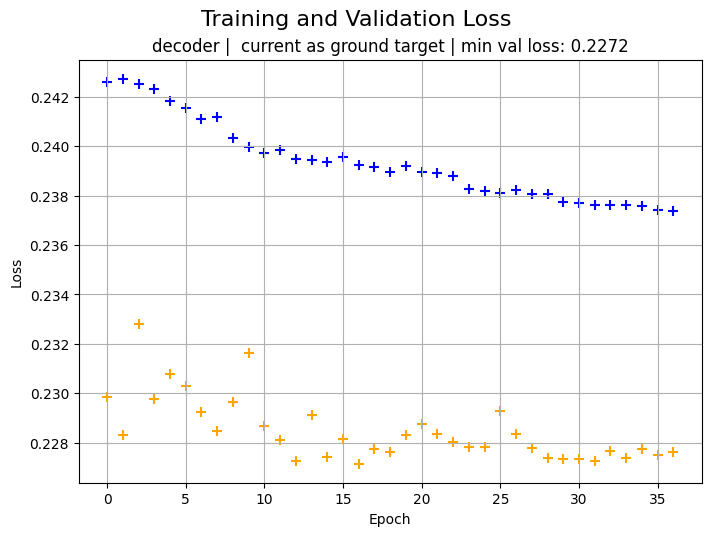

In [35]:
from proj_mod import visualization

train_loss_cut = train_loss[10:]
val_loss_cut = val_loss[10:]

vis_dict={("decoder","current as ground target"):{"train_loss": train_loss_cut,"val_loss": val_loss_cut}}
visualization.training_plots(vis_dict, fig_width=7)

### Another proof of concecpt model 

Thus far, we have only adjusted the final output of (as a sum of elements of sequence) of a model with timeseries input (like rnn). What if we adjust each element instead? 

In [ ]:
class exp_model2(nn.Module):
    def __init__(self): 
        super().__init__()
        self.param_emb=nn.ModuleList([
            nn.Linear(in_features=8,out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=60), 
            # nn.Tanh() # Current test: best with
        ])
        self.rnn_layer=training.RV_RNN_conv(rnn_num_layer=1,rnn_drop_out=0,n_diff=2,rnn_type="gru",return_sum=False)
    
    def forward(self,x):
        x_ts, x_tab=x[:,ts_place[0]:ts_place[1]], x[:,tab_place[0]:tab_place[1]]/1000 #I first added the /1000 here to scale the tab features a little, In this case, it did help: 0.2273 with /1000 and 0.2291 without. I think this is because the values are "too far away" from the values of each element of rnn output sequence. 
        
        rnn_out_seq=self.rnn_layer(x_ts)
        for layer in self.param_emb: 
            x_tab=layer(x_tab)
        x_tab=x_tab.unsqueeze(-1)
        # print(x_tab.shape)
        # print(rnn_out_seq.shape)
        # print(torch.sum(rnn_out_seq*x_tab,dim=1).shape)
        # return torch.sum(rnn_out_seq+rnn_out_seq*x_tab,dim=1) # Current test: Best with
        return torch.sum(rnn_out_seq*x_tab,dim=1) # Current test: best without

In [62]:
example2=exp_model2().to(device=device)

In [63]:
#Create the optimizer and the scheduler 
import torch.optim as optim

optimizer = optim.AdamW(example2.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

In [64]:
#Show summary
from torchinfo import summary
summary(example2)

Layer (type:depth-idx)                   Param #
exp_model2                               --
├─ModuleList: 1-1                        --
│    └─Linear: 2-1                       576
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       8,320
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       7,740
├─RV_RNN_conv: 1-2                       --
│    └─frozen_diff_conv: 2-6             --
│    │    └─Conv1d: 3-1                  (2)
│    └─Linear: 2-7                       128
│    └─GRU: 2-8                          6,336
│    └─Linear: 2-9                       33
Total params: 23,135
Trainable params: 23,133
Non-trainable params: 2

In [65]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Loss tracking
train_loss = []
val_loss = []

In [66]:
eample_weight_dict2=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=example2,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2400, device='cuda:0') .
At  11.515148878097534  epoch  1 has training loss  tensor(0.2991, device='cuda:0')  and validation loss  tensor(0.2400, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2335, device='cuda:0') .
A new best validation loss at epoch  3  with validation loss of  tensor(0.2334, device='cuda:0') .
At  61.016361951828  epoch  5 has training loss  tensor(0.2497, device='cuda:0')  and validation loss  tensor(0.2337, device='cuda:0') .

A new best validation loss at epoch  7  with validation loss of  tensor(0.2321, device='cuda:0') .
At  122.65967845916748  epoch  10 has training loss  tensor(0.2471, device='cuda:0')  and validation loss  tensor(0.2345, device='cuda:0') .

A new best validation loss at epoch  11  with validation loss of  tensor(0.2321, device='cuda:0') .
A new best validation loss at epoch  13  with validation loss of  tensor(0.2308, de

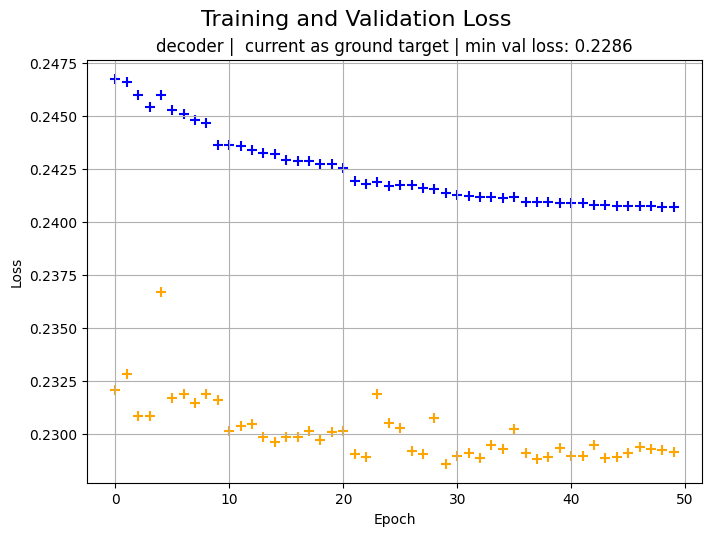

In [67]:
from proj_mod import visualization

train_loss_cut = train_loss[10:]
val_loss_cut = val_loss[10:]

vis_dict={("decoder","current as ground target"):{"train_loss": train_loss_cut,"val_loss": val_loss_cut}}
visualization.training_plots(vis_dict, fig_width=7)

In above, I am only using parameters of row id for embedding as example, I think things can improve when we use time and stock parameters as well. This can go beyond of just stock id since it can learn "similarity of time id" according to its parameters. While learned discrete embedding as we implemented in Learned_emb_RNN.ipynb can not do this for time id: They have not seen the future time id's in the test set. 

## Yet another proof of concept model: Let's do all of time id param embedding, stock id param embedding, stock id learned discrete embedding and row id param embedding. 

### Create dataset with the full df_total

In [50]:
df_total.columns

Index(['price_mean', 'price_std', 'size_sum', 'size_mean', 'size_std',
       'order_count_sum', 'order_count_mean', 'order_count_std', 'row_id',
       'time_id', 'stock_id', 'price_mean_time_id_mean',
       'price_mean_time_id_std', 'size_sum_time_id_mean',
       'size_sum_time_id_std', 'order_count_sum_time_id_mean',
       'order_count_sum_time_id_std', 'price_mean_stock_id_mean',
       'price_mean_stock_id_std', 'size_sum_stock_id_mean',
       'size_sum_stock_id_std', 'order_count_sum_stock_id_mean',
       'order_count_sum_stock_id_std', 'emb_id'],
      dtype='object')

In [54]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

tab_features=['price_mean', 'price_std', 'size_sum', 'size_mean', 'size_std',
       'order_count_sum', 'order_count_mean', 'order_count_std','price_mean_time_id_mean',
       'price_mean_time_id_std', 'size_sum_time_id_mean',
       'size_sum_time_id_std', 'order_count_sum_time_id_mean',
       'order_count_sum_time_id_std', 'price_mean_stock_id_mean',
       'price_mean_stock_id_std', 'size_sum_stock_id_mean',
       'size_sum_stock_id_std', 'order_count_sum_stock_id_mean',
       'order_count_sum_stock_id_std', 'emb_id']

norm_feature_dict={col:None for col in tab_features}
del norm_feature_dict["emb_id"]

train_dataset=training.RVdataset(time_id_list=train_time_id,
                                 ts_features=["sub_int_RV"],
                                 tab_features=tab_features,
                                 df_ts_feat=df_RV_ts,
                                 df_target=df_target,
                                 df_tab_feat=df_total,
                                 norm_feature_dict=norm_feature_dict)
test_dataset=training.RVdataset(time_id_list=test_time_id,
                                 ts_features=["sub_int_RV"],
                                 tab_features=tab_features,
                                 df_ts_feat=df_RV_ts,
                                 df_target=df_target,
                                 df_tab_feat=df_total,
                                 norm_feature_dict=norm_feature_dict)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .

Notice: price_mean has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: price_std has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: size_sum has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: size_mean has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: size_std has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: order_count_sum has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: order_count_mean has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: order_count_std has been normalized.
The mean and std of this feature has been stored in feat_norm_dict
Notice: price_mean_time_id_mean has been normalized.
The

In [55]:
train_dataset.featureplace

{'sub_int_RV': (0, 60),
 'price_mean': (60, 61),
 'price_std': (61, 62),
 'size_sum': (62, 63),
 'size_mean': (63, 64),
 'size_std': (64, 65),
 'order_count_sum': (65, 66),
 'order_count_mean': (66, 67),
 'order_count_std': (67, 68),
 'price_mean_time_id_mean': (68, 69),
 'price_mean_time_id_std': (69, 70),
 'size_sum_time_id_mean': (70, 71),
 'size_sum_time_id_std': (71, 72),
 'order_count_sum_time_id_mean': (72, 73),
 'order_count_sum_time_id_std': (73, 74),
 'price_mean_stock_id_mean': (74, 75),
 'price_mean_stock_id_std': (75, 76),
 'size_sum_stock_id_mean': (76, 77),
 'size_sum_stock_id_std': (77, 78),
 'order_count_sum_stock_id_mean': (78, 79),
 'order_count_sum_stock_id_std': (79, 80),
 'emb_id': (80, 81)}

In [180]:
ts_place, row_param_palce, time_param_place, stock_param_place, emb_id_place=(0,60), (60,68), (68,74), (74,80), (80,81)

In [185]:
train_dataset.__getitem__(0)[0][emb_id_place[0]:emb_id_place[1]]

tensor([0.])

### Create the example model

In [211]:
class exp_model3(nn.Module):
    def __init__(self): 
        super().__init__()
        self.rnn_layer=training.RV_RNN_conv(rnn_num_layer=1,rnn_drop_out=0,n_diff=2,rnn_type="gru",return_sum=True)
        self.row_param_layers=nn.ModuleList([
            nn.Linear(in_features=8,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ])
        self.time_param_layers=nn.ModuleList([
            nn.Linear(in_features=6,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ])
        self.stock_param_layers=nn.ModuleList([
            nn.Linear(in_features=6,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ])
        self.id_embeder = nn.Embedding(num_embeddings=112, embedding_dim=8)
        self.emb_id_layers=nn.ModuleList([
            nn.Linear(in_features=8,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ])
        self.adj_pos_emb=training.pos_emb_cross_attn(length=4,ts_dim=1,emb_dim=4,dropout=0.1,num_heads=1,keep_mag=True)
        self.adj_linear1=nn.Linear(in_features=4,out_features=16)
        self.adj_self_attn1=nn.MultiheadAttention(embed_dim=16,num_heads=4,dropout=0.1)
        self.adj_norm1=nn.LayerNorm(16)
        self.adj_self_attn2=nn.MultiheadAttention(embed_dim=16,num_heads=4,dropout=0.1)
        self.adj_norm2=nn.LayerNorm(16)
        self.adj_linear2=nn.Linear(in_features=16,out_features=1)
        self.final_linaer=nn.Linear(in_features=4, out_features=1)
        self.final=nn.Tanh()
    
    def forward(self,x): 
        x_ts , x_row, x_time, x_stock, x_embid = x[:,ts_place[0]:ts_place[1]], x[:,row_param_palce[0]:row_param_palce[1]], x[:,time_param_place[0]:time_param_place[1]], x[:,stock_param_place[0]:stock_param_place[1]], x[:,emb_id_place[0]:emb_id_place[1]].long()
        # print(x.size(),x[:,80])
        rnn_out=self.rnn_layer(x_ts)
        row_adj=x_row#.unsqueeze(-1)
        for layer in self.row_param_layers: 
            row_adj=layer(row_adj)
        time_adj=x_time#.unsqueeze(-1)
        for layer in self.time_param_layers: 
            time_adj=layer(time_adj)
        stock_adj=x_stock#.unsqueeze(-1)
        for layer in self.stock_param_layers:
            stock_adj=layer(stock_adj)
        emb_adj=self.id_embeder(x_embid)
        # print(emb_adj)
        for layer in self.emb_id_layers:
            emb_adj=layer(emb_adj)
        # emb_adj=emb_adj.squeeze()
        # print(emb_adj)
        emb_adj=torch.squeeze(emb_adj, dim=1)
        # print(row_adj.shape, time_adj.shape, stock_adj.shape, emb_adj.shape)
        adj=torch.cat((row_adj,time_adj,stock_adj,emb_adj),dim=-1).unsqueeze(-1)
        adj=self.adj_pos_emb(adj)
        adj=self.adj_linear1(adj)
        adj=(adj+self.adj_norm1(self.adj_self_attn1(adj,adj,adj)[0]))/2
        adj=(adj+self.adj_norm2(self.adj_self_attn2(adj,adj,adj)[0]))/2
        adj=self.adj_linear2(adj).squeeze()
        adj=self.final_linaer(adj)
        adj=self.final(adj)
        return rnn_out+rnn_out*adj 
        
        

In [212]:
example3=exp_model3().to(device=device)

In [213]:
#Create the optimizer and the scheduler 
import torch.optim as optim

optimizer = optim.AdamW(example3.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

In [214]:
#Show summary
from torchinfo import summary
summary(example3, input_size=(512,81))

Layer (type:depth-idx)                   Output Shape              Param #
exp_model3                               [512, 1]                  --
├─RV_RNN_conv: 1-1                       [512, 1]                  --
│    └─frozen_diff_conv: 2-1             [512, 3, 60]              --
│    │    └─Conv1d: 3-1                  [512, 1, 59]              (2)
│    │    └─Conv1d: 3-2                  [512, 1, 58]              (recursive)
│    └─Linear: 2-2                       [512, 60, 32]             128
│    └─GRU: 2-3                          [512, 60, 32]             6,336
│    └─Linear: 2-4                       [512, 60, 1]              33
├─ModuleList: 1-2                        --                        --
│    └─Linear: 2-5                       [512, 32]                 288
│    └─ReLU: 2-6                         [512, 32]                 --
│    └─Linear: 2-7                       [512, 32]                 1,056
│    └─ReLU: 2-8                         [512, 32]                 

In [215]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

# Loss tracking
train_loss = []
val_loss = []

In [216]:
eample_weight_dict3=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=example3,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2279, device='cuda:0') .
At  15.272334098815918  epoch  1 has training loss  tensor(0.2854, device='cuda:0')  and validation loss  tensor(0.2279, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2208, device='cuda:0') .
A new best validation loss at epoch  3  with validation loss of  tensor(0.2199, device='cuda:0') .
At  82.38528609275818  epoch  5 has training loss  tensor(0.2265, device='cuda:0')  and validation loss  tensor(0.2201, device='cuda:0') .

A new best validation loss at epoch  6  with validation loss of  tensor(0.2197, device='cuda:0') .
A new best validation loss at epoch  7  with validation loss of  tensor(0.2176, device='cuda:0') .
A new best validation loss at epoch  10  with validation loss of  tensor(0.2153, device='cuda:0') .
At  164.81026077270508  epoch  10 has training loss  tensor(0.2241, device='cuda:0')  and validation loss  tensor(0.2153, de

In [217]:
torch.save(eample_weight_dict3,"../model_data/wd_exp_model3Aug625.pth")

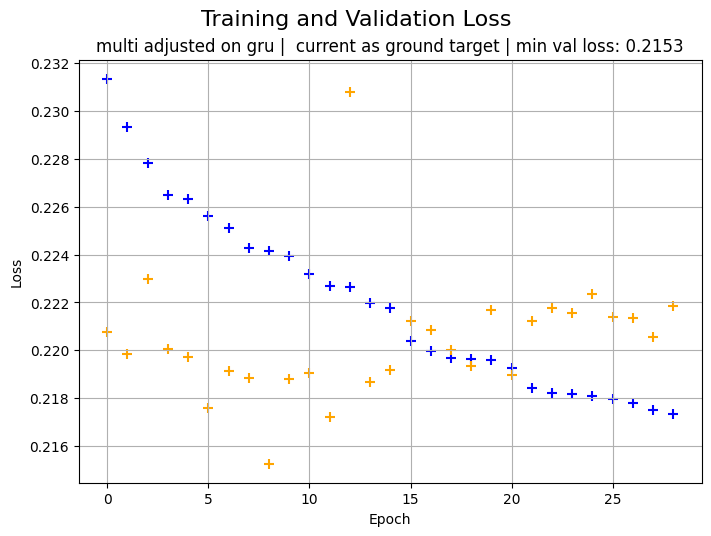

In [220]:
from proj_mod import visualization

train_loss_cut = train_loss[1:]
val_loss_cut = val_loss[1:]

vis_dict={("multi adjusted on gru","current as ground target"):{"train_loss": train_loss_cut,"val_loss": val_loss_cut}}
visualization.training_plots(vis_dict, fig_width=7)

# We have finally broke the 0.21 line !!!

## Creating a more flexible multi adjust model as subclass 

In [252]:
#Reload models for easier debugging 
sys.path.append("../")
from proj_mod import training, data_processing, visualization
importlib.reload(training);
importlib.reload(data_processing);
importlib.reload(visualization);

### The submodels and parameters 

In [253]:
# Create the base model, I am using the encoder decoder teacher forcing transformer as base model. This can be anything, like lstm and gru. 
ts_emb_dim=32
n_diff=2
ts_dim=n_diff+1
dropout=0.2
encoder_layers_num=2
decoder_layers_num=2
encoder_num_heads=4
decoder_num_heads=4

pos_embedder=training.pos_emb_cross_attn(length=60,ts_dim=ts_dim,emb_dim=ts_emb_dim,dropout=dropout,num_heads=4,keep_mag=True).to(device=device)

ts_encoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

ts_decoder_ff_layer=[
    nn.Linear(in_features=ts_emb_dim,out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64,out_features=ts_emb_dim)
]

output_ff=nn.Sequential(
    nn.Linear(in_features=ts_emb_dim,out_features=1)
).to(device=device)

base_model=training.encoder_decoder_teacherforcing(
        pos_emb_model=pos_embedder,
        output_feedforward=output_ff,
        encoder_dropout=dropout,
        decoder_dropout=dropout,
        encoder_feedforward_list=ts_encoder_ff_layer,
        decoder_feedforward_list=ts_decoder_ff_layer,
        n_diff=n_diff,
        encoder_layer_num=encoder_layers_num,
        decoder_layer_num=decoder_layers_num,
        input_scaler=10000,
        ts_emb_dim=ts_emb_dim,
        encoder_num_heads=encoder_num_heads,
        decoder_num_heads=decoder_num_heads,
        encoder_keep_mag=True,
        decoder_keep_mag=True,
        return_sum=True
    ).to(device=device)

In [254]:
#Show summary
from torchinfo import summary
summary(base_model, input_size=(512,60))

Layer (type:depth-idx)                   Output Shape              Param #
encoder_decoder_teacherforcing           [512, 1]                  --
├─frozen_diff_conv: 1-1                  [512, 3, 60]              --
│    └─Conv1d: 2-1                       [512, 1, 59]              (2)
│    └─Conv1d: 2-2                       [512, 1, 58]              (recursive)
├─pos_emb_cross_attn: 1-2                [512, 60, 32]             --
│    └─Linear: 2-3                       [512, 60, 32]             128
│    └─Embedding: 2-4                    [512, 60, 32]             1,920
│    └─MultiheadAttention: 2-5           [512, 60, 32]             4,224
│    └─LayerNorm: 2-6                    [512, 60, 32]             64
├─ModuleList: 1-3                        --                        --
│    └─ts_encoder: 2-7                   [512, 60, 32]             --
│    │    └─MultiheadAttention: 3-1      [512, 60, 32]             4,224
│    │    └─LayerNorm: 3-2               [512, 60, 32]           

In [255]:
# Create layer lists: 
ts_place, row_param_palce, time_param_place, stock_param_place, emb_id_place=(0,60), (60,68), (68,74), (74,80), (80,81)
stock_emb_dim=8
adj_proj_dim=16

row_layers=[
            nn.Linear(in_features=8,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ]

time_layers=[
            nn.Linear(in_features=6,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ]

stock_layers=[
            nn.Linear(in_features=6,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ]

emb_layers=[
            nn.Linear(in_features=stock_emb_dim,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32,out_features=1)
        ]

adj_ec_ff=[
            nn.Linear(in_features=adj_proj_dim,out_features=adj_proj_dim*2),
            nn.ReLU(),
            nn.Linear(in_features=adj_proj_dim*2,out_features=adj_proj_dim)
        ]

adj_layers=[
            training.ts_encoder(ts_dim=adj_proj_dim,dropout=0.2,feedforward_layer_list=adj_ec_ff,keep_mag=True,num_heads=4)
            for _ in range(2)
        ]

In [256]:
adj_pos_emb_dim=8
multi_adj_model=training.multi_adj_by_attd(base_model=base_model,
                                           adj_layers=adj_layers,
                                           ts_place=ts_place,
                                           row_layers=row_layers,
                                           row_place=row_param_palce,
                                           time_layers=time_layers,
                                           time_place=time_param_place,
                                           stock_layers=stock_layers,
                                           stock_place=stock_param_place,
                                           emb_layers=emb_layers,
                                           emb_place=emb_id_place,
                                           stock_emb_dim=stock_emb_dim,
                                           adj_pos_emb_dim=adj_pos_emb_dim,
                                           adj_pos_num_heads=2,
                                           adj_proj_dim=adj_proj_dim).to(device=device)

In [ ]:
#Create the optimizer and the scheduler 
import torch.optim as optim

optimizer = optim.AdamW(multi_adj_model.parameters(), lr=1e-3)

scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode="min",factor=0.5,patience=5,min_lr=1e-7)

# Loss tracking
train_loss = []
val_loss = []

In [258]:
#Show summary
from torchinfo import summary
summary(multi_adj_model, input_size=(512,81))

Layer (type:depth-idx)                        Output Shape              Param #
multi_adj_by_attd                             [512, 1]                  --
├─encoder_decoder_teacherforcing: 1-1         [512, 1]                  --
│    └─frozen_diff_conv: 2-1                  [512, 3, 60]              --
│    │    └─Conv1d: 3-1                       [512, 1, 59]              (2)
│    │    └─Conv1d: 3-2                       [512, 1, 58]              (recursive)
│    └─pos_emb_cross_attn: 2-2                [512, 60, 32]             --
│    │    └─Linear: 3-3                       [512, 60, 32]             128
│    │    └─Embedding: 3-4                    [512, 60, 32]             1,920
│    │    └─MultiheadAttention: 3-5           [512, 60, 32]             4,224
│    │    └─LayerNorm: 3-6                    [512, 60, 32]             64
│    └─ModuleList: 2-3                        --                        --
│    │    └─ts_encoder: 3-7                   [512, 60, 32]             8,544


In [259]:
multi_adj_weight_dict3=training.reg_training_loop_rmspe(
    optimizer=optimizer,
    model=multi_adj_model,
    train_loader=train_loader,
    val_loader=test_loader,
    ot_steps=20,
    report_interval=5,
    n_epochs=200,
    list_train_loss=train_loss,
    list_val_loss=val_loss,
    device=device,
    eps=1e-8,
    scheduler=scheduler)

A new best validation loss at epoch  1  with validation loss of  tensor(0.2227, device='cuda:0') .
At  30.75628161430359  epoch  1 has training loss  tensor(0.2889, device='cuda:0')  and validation loss  tensor(0.2227, device='cuda:0') .

A new best validation loss at epoch  2  with validation loss of  tensor(0.2176, device='cuda:0') .
A new best validation loss at epoch  3  with validation loss of  tensor(0.2164, device='cuda:0') .
At  158.67426228523254  epoch  5 has training loss  tensor(0.2274, device='cuda:0')  and validation loss  tensor(0.2183, device='cuda:0') .

At epoch 9, learning rate has been updated from 0.001 to 0.0005, reloading previous best model weights from epoch 3 ...

Previous best model weights reloaded, training continues ... 
At  319.09208154678345  epoch  10 has training loss  tensor(0.2229, device='cuda:0')  and validation loss  tensor(0.2193, device='cuda:0') .

At  478.3002064228058  epoch  15 has training loss  tensor(0.2218, device='cuda:0')  and validati

Above more flexible model should be good for fine tuning. Some suggestions for fine tuning: Since the over train is very early, may be increase drop out, or change the optimizer with weight_decay like following: 

In [ ]:
# Example code 
optimizer = optim.AdamW(multi_adj_model.parameters(), lr=1e-3, weight_decay=1e-4) 

Above weight_decay punishes large weights by changing the update rule to: 

$$ \text{new weight} = \text{old weight} - \text{learning rate}\ \cdot \ (\text{gradient of loss} + \text{weight decay}\cdot\text{old weight})$$